In [1]:
import ale_py
import gymnasium as gym

from jax import numpy as jnp, random as jr, vmap

from matplotlib import pyplot as plt

from model import Tokenizer, forward_tokenizer, train_tokenizer

In [10]:
gym.register_envs(ale_py)

env = gym.make("ALE/Pong-v5", render_mode="rgb_array", frameskip=1)
env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=False, screen_size=(64, 64))

buffer = []
obs, info = env.reset()
episode_over = False
while not episode_over:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    buffer.append(obs)
    
    episode_over = terminated or truncated
env.close()

buffer = jnp.array(buffer) 
print(buffer.shape) 

(870, 64, 64, 3)


Total patches: (55680, 192)
9142.634
Tokenizer codes used: 10000
Nearest IDs for first 10 patches: [1 1 1 1 1 1 1 1 1 1]


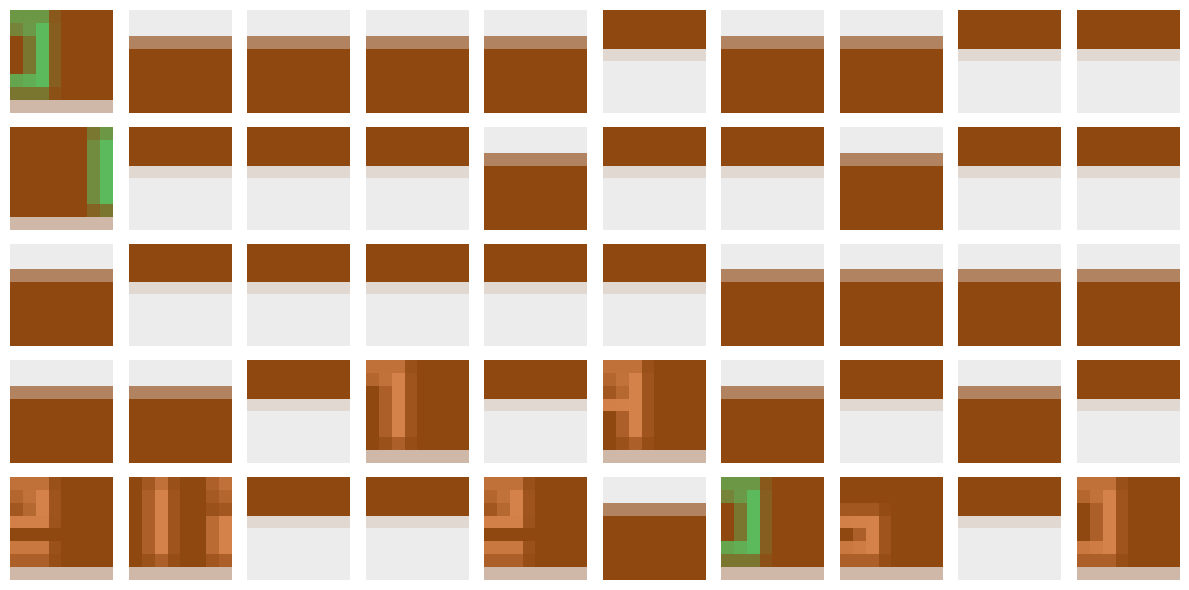

In [ ]:
N, H, W, C = buffer.shape

patch_size = 8
height_patches = 64 // patch_size  # 8
width_patches = 64 // patch_size  # 8

patches = buffer.reshape(N, height_patches, patch_size, width_patches, patch_size, 3)
# reorder and flatten to shape [N * 8*8, 8*8*3]
patches = patches.transpose(
    (0, 1, 3, 2, 4, 5)
)  # (N, 8, 8, 8, 8, 3) => (N, 8, 8, 8, 8, 3)
patches = patches.reshape(-1, patch_size * patch_size * 3)  # [N * 64, 192]

print("Total patches:", patches.shape)

# 2. Initialize tokenizer
dim = patch_size * patch_size * 3
max_codes = 10_000
tokenizer = Tokenizer(
    codes=jnp.zeros((max_codes, dim), dtype=jnp.float32),
    num_codes=1,
    distance_threshold=10_000,  
    max_codes=max_codes,
    no_code_id=-1,
)

tokenizer, patch_indices = train_tokenizer(tokenizer, patches)
print("Tokenizer codes used:", tokenizer.num_codes)

subset = patches[:10]
nearest_ids = forward_tokenizer(tokenizer, subset)
print("Nearest IDs for first 10 patches:", nearest_ids)

key = jr.PRNGKey(42)
n_show = jnp.minimum(tokenizer.num_codes, 50)

chosen_indices = jr.choice(key, tokenizer.num_codes, shape=(n_show,), replace=False)
code_samples = tokenizer.codes[chosen_indices]  

code_samples = jnp.clip(code_samples, 0, 255).astype(jnp.uint8)

def reshape_patch(code):
    return code.reshape(patch_size, patch_size, 3)

reshaped_patches = vmap(reshape_patch)(code_samples)

rows, cols = 5, 10 
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(reshaped_patches[i])
    ax.axis("off")

plt.tight_layout()
plt.show()